# Exploratory Land Use and Land Cover Analysis

This Jupyter Notebook aims to present one way to explore and analysis Land Use and Land Cover (LULC) samples data to evaluate the samples quality to be used in machine learning algorithm. The Sample Assessment App code can be acessed by Github repository: [Sample Assessment App](https://github.com/AbnerErnaniADSFatec/sample-assessment).

## Abstract (Provisório)

Currently peta bytes of Earth observation data are generated [1], this extensive mass of data has motivated researchers with new ideas for mapping the Earth's surface with remote sensing, involving time series analysis, the production of classified maps, and for machine learning methods use. With the market for computational tools for the development of custom platforms overheating, a new perspective for the solution of problems such as the demand for accurate classified maps is emerging. This demand is on the rise because of increasingly unpredictable changes in land use and land cover, including wildfires, deforestation, industrial development, and other human-caused damage to the environment. Mapping these changes is critical for government agencies, so the accuracy of LULC samples must be assessed in a structured and efficient manner. For this reason, the present proposal aims to conduct a study on the exploratory analysis in LULC samples for the development of a collaborative web environment that allows the sharing of results. For this, tools will be used to create applications such as the Shiny framework in R language and the SITS package that was developed in the Brazil Data Cube - BDC project for the return and manipulation of remote sensing data. Thus, this environment seeks to contribute to the production of classified maps that catalog the changes in the environment.

## Methods

This proposal intends to use the SOM method implemented by the SITS package in R language combined with the Shiny package for web application development with R language and Jupyter Lab to make available to the user a collaborative environment for efficient analysis of samples as a software solution. The software solutions aim to facilitate access to analysis methods for researchers who do not have specific technical knowledge of information technology such as the application of programming languages and algorithm construction. In this case we are going to use this libs for sample data analysis:

 - [SITS - Satellite Image Time Series](https://github.com/e-sensing/sits): This package provides a set of tools for the analysis, visualization and classification of time series from satellite imagery. The main functionality of the `sits` package is support for the classification of land use and land cover changes in satellite imagery;
 
 - [SITS - Data](https://github.com/e-sensing/sitsdata): This project contains in situ data sets used in the e-sensing project. These data sets consists of time series of selected locations which are used to train the statistical learning models used in the e-sensing studies;
 
 - [dplyr](https://cran.r-project.org/web/packages/dplyr/index.html): is a new package which provides a set of tools for efficiently manipulating datasets in R;
 
 - [ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html): ggplot2 is a plotting package that makes it simple to create complex plots from data in a data frame;
 
 - [plotly](https://plotly.com/): this package provides online graphing, analytics, and statistics tools for individuals and collaboration, as well as scientific graphing libraries for Python, R, MATLAB, Perl, Julia, Arduino, and REST;
 
 - [stars](https://r-spatial.github.io/stars/): This R package provides classes and methods for reading, manipulating, plotting and writing such data cubes, to the extent that there are proper formats for doing so;
 
 - [leaflet](https://rstudio.github.io/leaflet/shiny.html): The Leaflet package includes powerful and convenient features for integrating with Shiny applications. 

First step is to import all needed libraries for analysis that are listed on [`install-requirements.r`](./install-requirements.r) file:

> Obs.: Whereas you walk step by step from [README.md](./README.md) or install by your own.

In [22]:
library(sits)
library(sitsdata)
library(dplyr)
library(ggplot2)
library(plotly)
library(stars)
library(leaflet)

We need to implement a method to facilitate the load of different format files like `.csv`, `.rda` and `.rds`.

This method verify the file extension and read the file to retriving the data `tibble`:

In [11]:
read_file <- function(file, ext) {
  data.tb <- NULL
  if (ext == "csv") {
    data.tb <- read.csv(file)
  }
  if (ext == "rds") {
    data.tb <- readRDS(file)
  }
  if (ext == "rda") {
    data.tb <- get(load(file))
  }
  return(data.tb)
}

Now let's create a method that convert the tibble data in a shapefile using the latitude and longitude attributes, soon this data will be described:

In [12]:
point_to_shape_sp <- function (data.tb, class_label) {
  group_shape <- dplyr::select(data.tb,
    longitude, latitude,
    start_date, end_date,
    label #, cube
  )
  sp_data.tb.df <- as.data.frame(group_shape)
  sp_data.tb.df <- sp_data.tb.df %>% filter(label == class_label)
  points_SF <- as.data.frame(sp_data.tb.df)
  xy <- points_SF[, c(1, 2)]
  sp_data.df <- sp::SpatialPointsDataFrame(
    coords = xy,
    data = points_SF,
    proj4string = sp::CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
  )
  return(sp_data.df)
}

## Loading data

The example data used here are from sitsdata repository. The repository data description about data format is: All data sets in the "data" directory are tibbles with satellite image time series, with the following columns:

 - **Longitude**: East-west coordinate of the time series sample in WGS 84;
 - **latitude**: North-south coordinate of the time series sample in WGS 84;
 - **Start Date**: initial date of the time series;
 - **End date**: final date of the time series;
 - **Label**: the class label associated to the sample;
 - **Cube**: the name of the image data cube associated with the data;
 - **Time Series**: list containing a tibble with the values of the time series.
 
The data to be used will be based mainly on:

 - **LULC samples**: land use and land cover classes based on geographic coordinates having metadata such as the spectrometer and period the classes were identified;

 - **Time series**: data collected from the stack of remote sensing images containing the value of the spectral bands through time units associated with a single geographic coordinate.
 
We are going to load a  LULC sample data about Sinop City at state of Mato Grosso in Brazil:

> Obs.: This data contains only the samples metadata without time series.

In [18]:
input_data.tb <- read_file("./data/samples_sinop_crop.csv", "csv")
head(input_data.tb, 5)

,id,longitude,latitude,start_date,end_date,label
,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,-55.65931,-11.76267,2013-09-14,2014-08-29,Pasture
2,2,-55.64833,-11.76385,2013-09-14,2014-08-29,Pasture
3,3,-55.66738,-11.78032,2013-09-14,2014-08-29,Forest
4,4,-55.64747,-11.75276,2013-09-14,2014-08-29,Pasture
5,5,-55.65742,-11.78788,2013-09-14,2014-08-29,Forest


The code below group the labels of all data set, count and after it calculates the percentage using `dplyr` methods:

In [19]:
group <- dplyr::group_by(input_data.tb, label)
agregation <- dplyr::summarise(group, n = n(), .groups = "drop_last")
mutation <- dplyr::mutate(agregation, percent = n/sum(n))
mutation <- data.frame(mutation)
mutation

label,n,percent
<chr>,<int>,<dbl>
Cerrado,3,0.1666667
Forest,3,0.1666667
Pasture,4,0.2222222
Soy_Corn,8,0.4444444


We can explore the data and your class labels by creating a pie chart visualization to understand the land coverage:

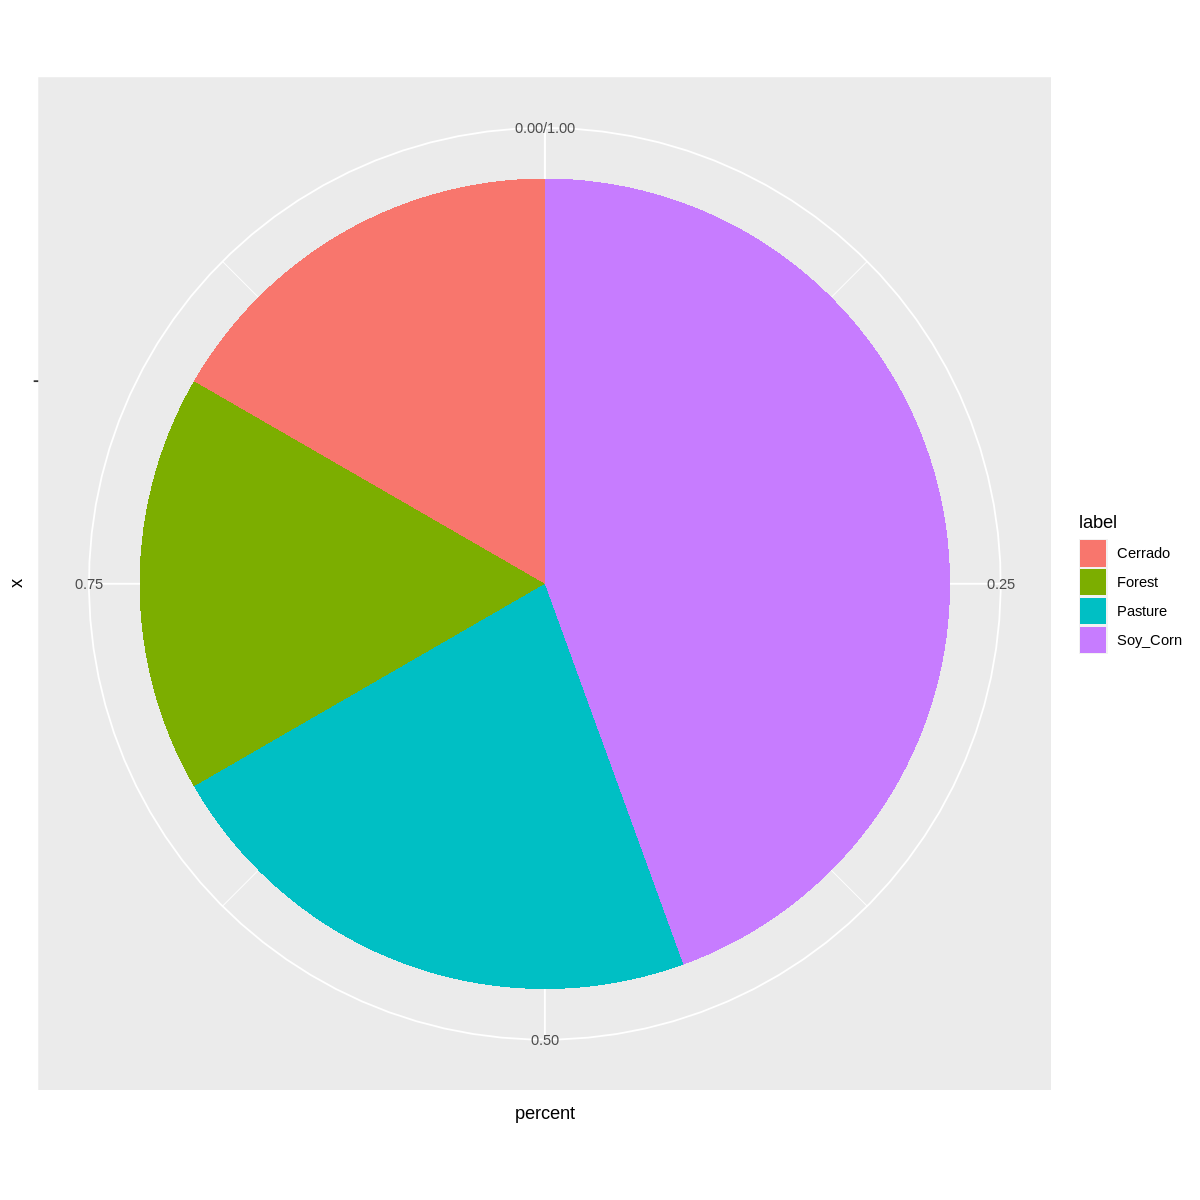

In [20]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(
    mutation,
    aes(x="", y=percent, fill=label)
) + geom_bar(width = 1, stat = "identity") + coord_polar("y", start=0)

Now we can view this samples on map based on latitude and longitude from data set and fillter by label `Soy_Corn`.

We are using `leaflet` package to set a map view with markers:

In [24]:
shape <- point_to_shape_sp(
    data.tb = input_data.tb,
    class_label = "Soy_Corn"
)
leaflet(shape, options = leafletOptions(minZoom = 0, maxZoom = 100)) %>%
        addTiles() %>%
            addMarkers(
                ~longitude, ~latitude,
                popup = ~as.character(
                    paste("Class '", label, "' |",
                        format(
                            as.Date(start_date),
                            format = "Start %Y-%m-%d"
                        ),
                        format(
                            as.Date(end_date),
                            format = "End %Y-%m-%d"
                        )
                    )))

> Obs.: The code above will generate a map output that is not visible on github:
> <p align = "center">
  <img src = "./img/leaflet_output_soy_corn_label.png">
</p>

## Getting Time Series

With the classified geometries, the time series extraction process is based on the WTSS service, where two columns are added, one referring to the collection that provides the time series and the data of the collected spectral bands.

With the two extra columns it is possible to identify the spatiotemporal patterns in the samples [3].

We will explore two ways to get time series from images provided by remote sensing.

The first way is by `SITS` package. In this way we need to download the images from data provider and read then using `sits cube` to create a local data cube.

The second way is by `WTSS` service and client developed and distributed by Brazil Data Cube. In this way we only need to fill the parameters required like area of interest and the period and get the response, this way takes longer because is a HTTP request and depends on internet.

### SITS

The package [`SITS - Satellite Image Time Series`](https://github.com/e-sensing/sits) Analysis for Earth Observation Data Cubes provides a set of tools for series analysis, classification and classification from satellite images.

The main functionality of the `sits` package is support for classification of land use and land cover changes in satellite images.

The `sits` Workflow:

   - Creation of a data cube using image collections from cloud or local services;
   - Extraction of time series;
   - Analysis and evaluation of his;
   - Machine learning algorithms training;
   - Classification of a data cube using the machine learning model;
   - Post processing of images;
   - Evaluation of the accuracy generated by the model using best practices;

To create a local data cube we need to fill a simple form with required parameters:

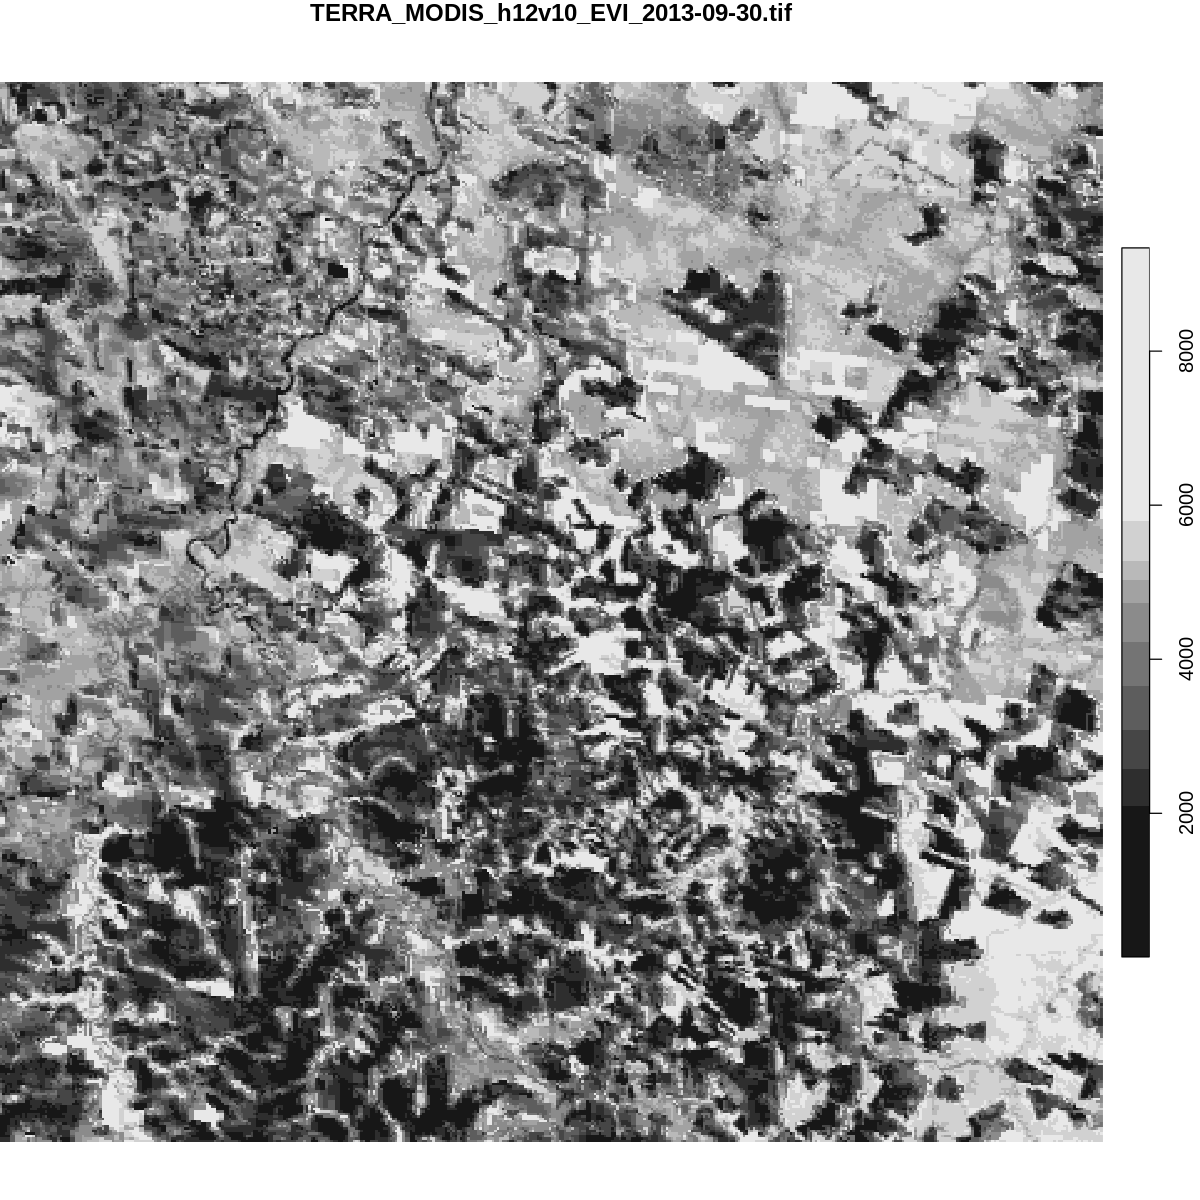

In [25]:
data_dir <- system.file("extdata/sinop", package = "sitsdata")
raster_cube <- sits_cube(
        source = "LOCAL",
        name = "sinop-2014",
        satellite = "TERRA",
        sensor = "MODIS",
        data_dir = data_dir
)
options(repr.plot.width = 10, repr.plot.height = 10)
plot(raster_cube, band = "EVI", time = 2)

With the `sits` package we can load the data set `.csv` and get the time series by the data cube created before using the `sits_get_data` method:

> Obs.: A data set in sits format will be returned with time series coupled with labels and coordinates:

In [27]:
points <- sits_get_data(raster_cube, file = "./data/samples_sinop_crop.csv")
head(points, 1)

All points have been retrieved



longitude,latitude,start_date,end_date,label,cube,time_series
<dbl>,<dbl>,<date>,<date>,<chr>,<chr>,<list>
-55.65931,-11.76267,2013-09-14,2014-08-29,Pasture,sinop-2014,"15962.0000, 15978.0000, 15994.0000, 16010.0000, 16026.0000, 16042.0000, 16058.0000, 16071.0000, 16087.0000, 16103.0000, 16119.0000, 16135.0000, 16151.0000, 16167.0000, 16183.0000, 16199.0000, 16215.0000, 16231.0000, 16247.0000, 16263.0000, 16279.0000, 16295.0000, 16311.0000, 0.2106, 0.3169, 0.2674, 0.3430, 0.3897, 0.4803, 0.5254, 0.5254, 0.4680, 0.4708, 0.1790, 0.3151, 0.4756, 0.4006, 0.4509, 0.4284, 0.3551, 0.3730, 0.3146, 0.2480, 0.1967, 0.1883, 0.2211, 0.3386, 0.4327, 0.4608, 0.5664, 0.4799, 0.5867, 0.6543, 0.6543, 0.6912, 0.6439, 0.1721, 0.7537, 0.7299, 0.6144, 0.6653, 0.6510, 0.5940, 0.6135, 0.5229, 0.4271, 0.3451, 0.3182, 0.3272"


A sample of time series returned from this operation can be visualized below:

In [28]:
head(tibble(points$time_series[[1]]), 3)

Index,EVI,NDVI
<date>,<dbl>,<dbl>
2013-09-14,0.2106,0.3386
2013-09-30,0.3169,0.4327
2013-10-16,0.2674,0.4608


And now we can view the data in line chart using plot:

> Note: The bands shown in chart are provided by the filename of downloaded images like "EVI" and "NDVI" suffix.

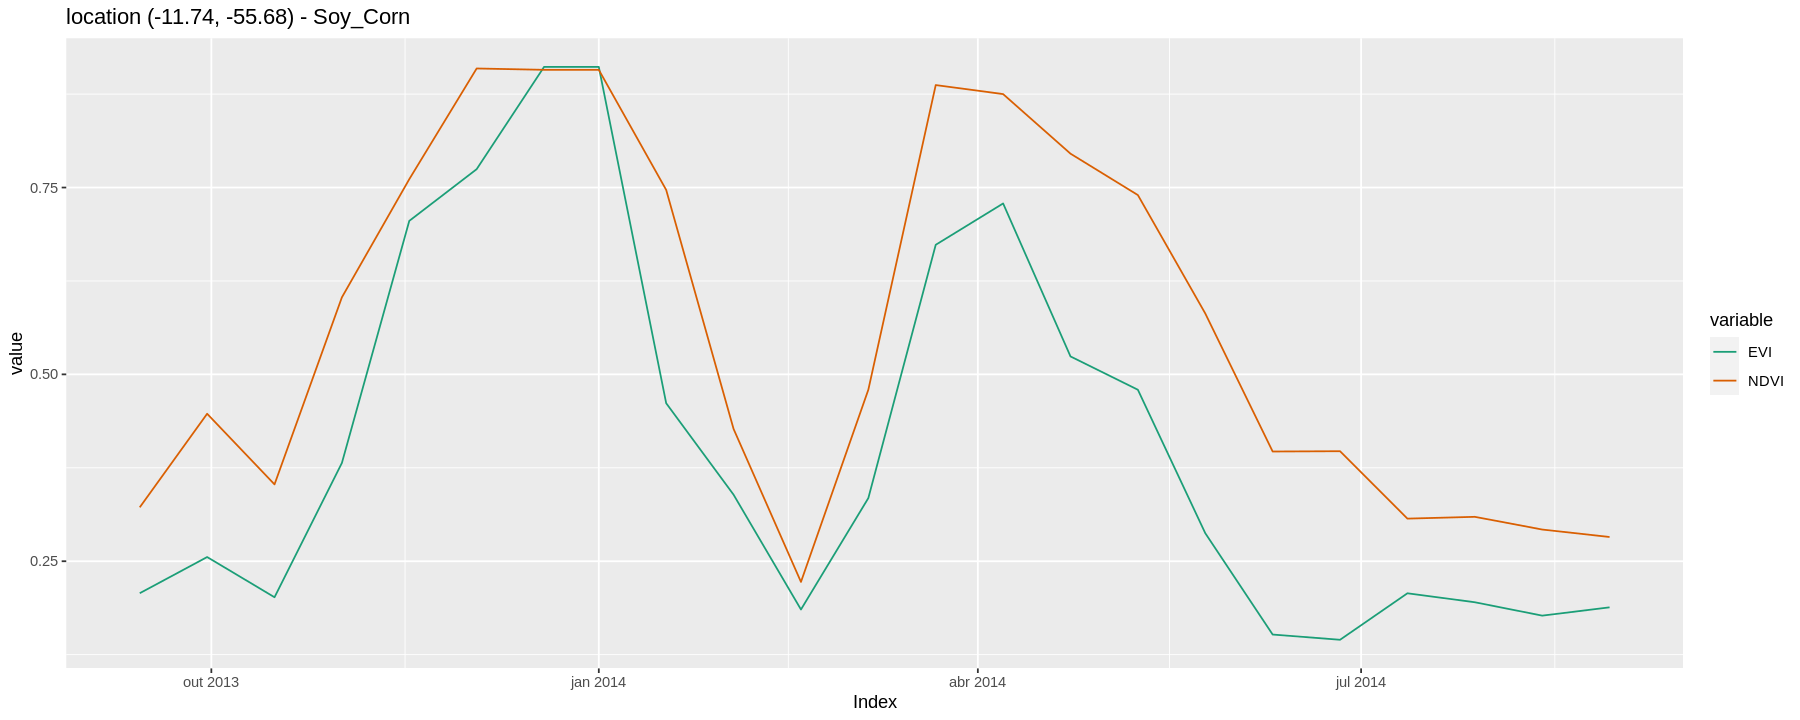

In [30]:
options(repr.plot.width = 15, repr.plot.height = 6)
filtered <- dplyr::filter(points, label == "Soy_Corn")
plot(filtered[1,])

### WTSS

_"The Rwtss package is a front-end to the Web Time Series Service (WTSS) that offers time series of remote sensing data using a simple API. A WTSS server takes as input an Earth observation data cube, that has a spatial and a temporal dimension and can be multidimensional in terms of its attributes. The WTSS API has three commands, which are are (a) list_coverages, that returns a list of coverages available in the server; (b) describe_coverage, that that returns the metadata for a given coverage; (c) time_series, that returns a time series for a spatio-temporal location."_

This description is provided by [`R wtss Package`](https://github.com/e-sensing/Rwtss) repository.

To retrieve time series data from the WTSS Service, we need to fill in parameters such as coordinates and period, this parameters we can get from dataset.

We will select an sample randomly and get the time series data by its parameters:

In [33]:
wtss_inpe <- "https://brazildatacube.dpi.inpe.br/wtss/" # the server for wtss
coverage <- "MOD13Q1-6" # The selected coverage or cube
sample <- data.frame(head(input_data.tb, 1))
start <- sample$start_date
end <- sample$end_date
lat <- sample$latitude
long <- sample$longitude
bands <- c('NDVI', 'EVI', 'NIR_reflectance') # The selected bands

response = Rwtss::time_series(
    wtss_inpe, 
    name = coverage, 
    attributes = bands, 
    longitude = long,
    latitude  = lat,
    start_date = start, 
    end_date = end,
    token = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"
)
cube <- response$cube
ts <- data.frame(response$time_series)
head(ts, 3)

,Index,NDVI,NIR_reflectance,EVI
,<date>,<dbl>,<dbl>,<dbl>
1,2013-09-14,0.3532,0.3063,0.2201
2,2013-09-30,0.4216,0.3370,0.2693
3,2013-10-16,0.4831,0.2680,0.2732


Now we can view the data response by plot:

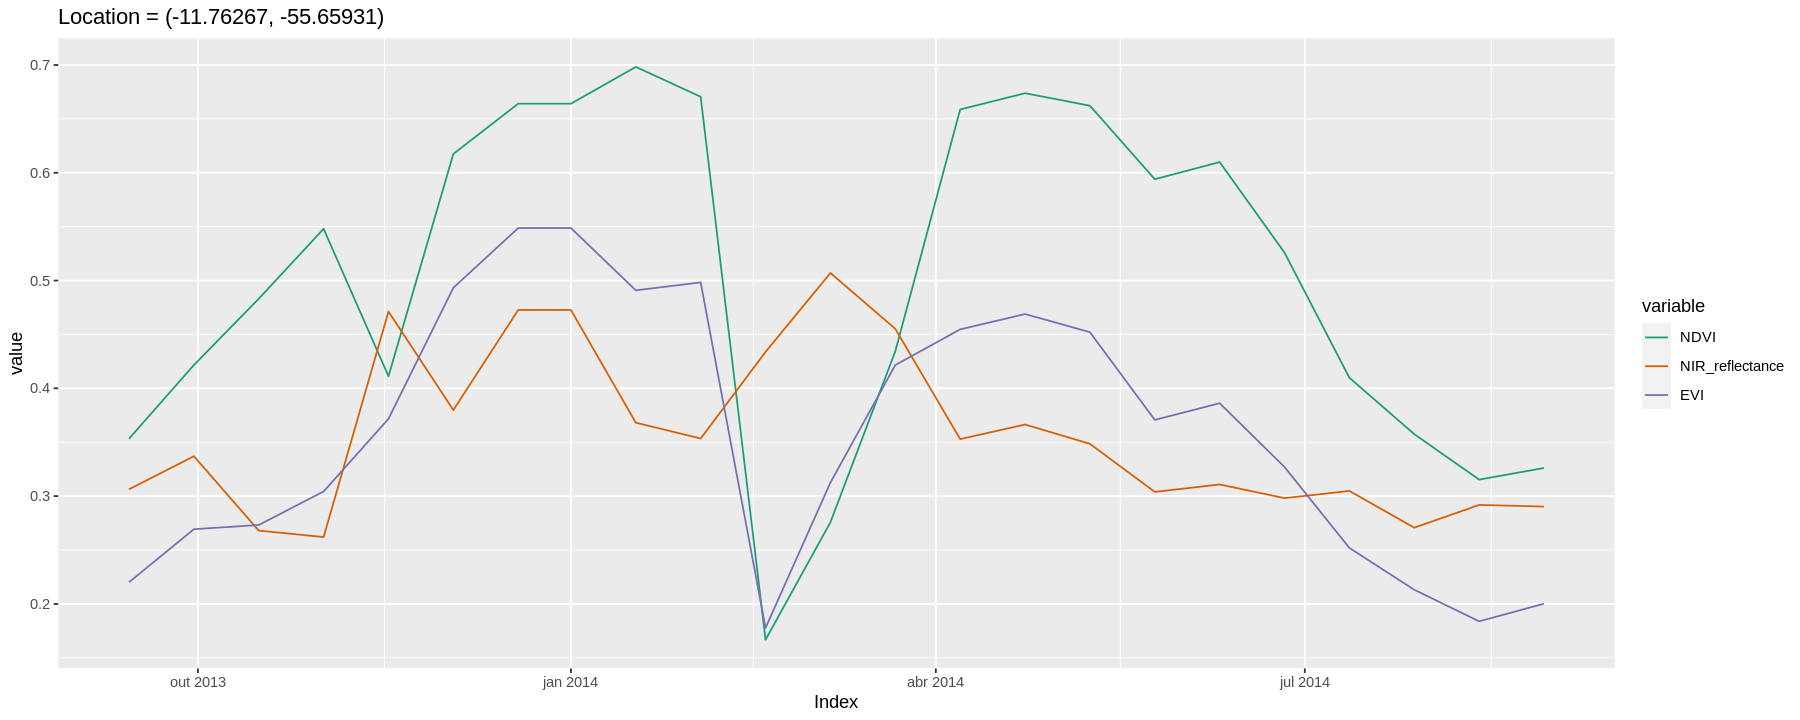

In [34]:
options(repr.plot.width = 15, repr.plot.height = 6)
plot(response)

## Final comments

As a result, it is expected to develop a case study about the environment for an exploratory analysis of UCT combined with time series collected from remote sensing images to present attributes that demonstrate the calculation of accuracy and quality of classified maps. It also seeks to develop software solutions for the dissemination of these methods to a scientific community that does not master information technology techniques.

## References

 - [1] Lorena A. Santos, Karine R. Ferreira, Gilberto Camara, Michelle C. A. Picoli, and Rolf E. Simoes. Quality control and class noise reduction of satellite image time series. ISPRS Journal of Photogrammetry and Remote Sensing, 177:75–88, 2021. 

 - [2] Rwanga, S.S. and Ndambuki, J.M. (2017) Accuracy Assessment of Land Use/Land Cover Classification Using Remote Sensing and GIS. International Journal of Geosciences, 8, 611-622. 

 - [3] Lorena Alves Santos, Karine Ferreira, Michelle Picoli, Gilberto Camara, Raul Zurita-Milla, and Ellen-Wien Augustijn. Identifying spatiotemporal patterns in land use and cover samples from satellite image time series. MDPI - Remote Sensing, 13(5):974, 2021. 